# Demo Code to benchmark UnitedMet 

This Jupyter Notebook is a fully runnable demo version of the imputation code and benchmark UnitedMet's performance to predict metabolite levels in ccRCC.
Current version was run with n_steps = 100 to get a quick demo, it didn't show the best performance.

## Import Dependencies

In [1]:
import os
os.chdir('/data1/reznike/xiea1/UnitedMet_public')
import torch
from itertools import repeat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from collections import Counter
from Performance_Benchmarking.scripts.data_processing import load_met_data, load_rna_data, data_normalization_cleaning, check_match
from Performance_Benchmarking.scripts.pyro_model import generate_pyro_data, run_pyro_svi,  svi_loss, pyro_posterior
from Performance_Benchmarking.scripts.utils import test_train_split_met_rna
from Performance_Benchmarking.scripts.testing import testing_function_met_rna, results_analysis, results_visualization, results_probabilistic_analysis

## Initialize Variables/Directories/Files

In [2]:
# Random seed
seed = 42
# Number of embedding dimensions for W and H
n_dims = 30
# verbose_embeddings: write W, and H posterior draws to .npy files
ve = True
# Iteration steps of pyro SVI
n_steps = 4000
# Learning rate of pyro SVI
lr = 0.001
# feature test/mask proportion
f_test_prop = 1
# the path of the parent directory for all input files
file_path = '/data1/reznike/xiea1/UnitedMet_public/data'
# input dir for paired RNA-seq reference data
rna_matched_data_dir = '/data1/reznike/xiea1/UnitedMet_public/data/RNA_matched_ccRCC'
# input dir for paired metabolomics reference data
met_matched_data_dir = '/data1/reznike/xiea1/UnitedMet_public/data/MET_matched_ccRCC'
# the directory to save all output files
results_dir = '/data1/reznike/xiea1/UnitedMet_public/results_UnitedMet_demo'
# not a pure imputation task, but a benchmarking evaluation task
imputation = False
# name of 4 ccRCC datasets
sub_dir = ['CPTAC', 'CPTAC_val', 'RC18', 'RC20']
# target dataset to hold out and predict
dir = 'RC18'
proportions = list(repeat(0, len(sub_dir)))
target = sub_dir.index(dir) + 1
proportions[target - 1] = 1

plots_dir = f'{results_dir}/plots'
embedding_dir = f'{results_dir}/embeddings'

for dir in [results_dir, plots_dir, embedding_dir]:
    try:
        os.makedirs(dir)
    except FileExistsError:
        print(f"Directory '{dir}' already exists.")

Directory '/data1/reznike/xiea1/UnitedMet_public/results_UnitedMet_demo' already exists.
Directory '/data1/reznike/xiea1/UnitedMet_public/results_UnitedMet_demo/plots' already exists.
Directory '/data1/reznike/xiea1/UnitedMet_public/results_UnitedMet_demo/embeddings' already exists.


## Load and process metabolomics and RNA-seq data

In [3]:
    MET_RNA_map = pd.read_csv(f'{file_path}/MasterMapping_ccRCC.csv', header=0, index_col='MetabID')
    met_data, metabolite_map, sample_map_met, met_batch_index_vector = load_met_data(met_matched_data_dir)

    rna_data, batch_index_vector, gene_map, sample_map_rna, batch_map, batch_sizes, start_row, stop_row, \
    s_test_prop_settings, n_batch = load_rna_data(rna_matched_data_dir,  proportions, imputation)
    # Check the order of samples in loaded RNA/MET datasets are matched and same as the order in the master map
    check_match(sample_map_met, sample_map_rna, MET_RNA_map, sub_dir, imputation, batch_index_vector)
    # Normalization, Concatenate MET and RNA data, and remove features with all NaNs
    data, met_data, rna_data, metabolite_map, gene_map, met_names, rna_names, feature_names, sample_names = \
        data_normalization_cleaning(met_data, rna_data, met_batch_index_vector, metabolite_map,
                                    gene_map, sample_map_rna, imputation, batch_index_vector, n_batch,
                                    start_row, stop_row)
    pd.DataFrame(data, index=sample_names, columns=feature_names).to_csv(
        f'{embedding_dir}/normalized_met_rna_data_pyro.csv')

The target dataset is assigned as follows ('1' indicates the target):
                     batches  s_test_prop
0      matched_tpm_CPTAC.csv            0
1  matched_tpm_CPTAC_val.csv            0
2       matched_tpm_RC18.csv            1
3       matched_tpm_RC20.csv            0
MetaID matched
RNAID matched
The aggregate data is clean.


## Generate preprocessed data for United model in pyro

In [4]:
N, J, K, n_obs, orders, ranks, censor_indicator = generate_pyro_data(data, n_dims, n_batch,                                                                            batch_index_vector)
n_obs_pre = np.copy(n_obs)  # save the n_obs of the original data

## Test/Train Split

In [5]:
np.random.seed(seed)
testing, training, n_obs, test_sample_indices, test_feature_indices, len_available = test_train_split_met_rna(
    met_data, start_row, stop_row, target, n_obs, ranks, f_test_prop)  # updated n_obs specify the training set

## Run UnitedMet model in pyro

In [ ]:
torch.manual_seed(seed)
W_loc, W_scale, H_loc, H_scale, loss_list = run_pyro_svi(N, J, K, n_batch, start_row, stop_row, n_obs, orders, n_steps, lr)
svi_loss(loss_list, plots_dir)  # plot the loss function of the model

with open(f'{embedding_dir}/W_H_loc_scale.npy', 'wb') as f:  # 'wb': write as binary
    np.save(f, W_loc)
    np.save(f, W_scale)
    np.save(f, H_loc)
    np.save(f, H_scale)
    f.close()

  0%|          | 1/4000 [00:05<5:39:54,  5.10s/it]

step 0: loss = 25962885.956054688


  3%|▎         | 101/4000 [06:28<4:49:56,  4.46s/it]

step 100: loss = 25575181.213867188


  5%|▌         | 201/4000 [14:32<5:24:38,  5.13s/it]

step 200: loss = 24663352.236328125


  8%|▊         | 301/4000 [22:47<5:14:11,  5.10s/it]

step 300: loss = 24124024.872070312


 10%|█         | 401/4000 [29:59<3:10:58,  3.18s/it]

step 400: loss = 23688805.1015625


 13%|█▎        | 501/4000 [35:14<2:50:16,  2.92s/it]

step 500: loss = 23319179.905273438


 15%|█▌        | 601/4000 [40:18<2:48:26,  2.97s/it]

step 600: loss = 23039892.569335938


 18%|█▊        | 701/4000 [45:49<3:31:03,  3.84s/it]

step 700: loss = 22816254.748046875


 20%|██        | 801/4000 [52:03<2:49:25,  3.18s/it]

step 800: loss = 22624550.944335938


 23%|██▎       | 901/4000 [57:20<2:58:37,  3.46s/it]

step 900: loss = 22462443.490234375


 25%|██▌       | 1001/4000 [1:02:51<2:35:28,  3.11s/it]

step 1000: loss = 22306904.541992188


 28%|██▊       | 1101/4000 [1:09:17<3:40:26,  4.56s/it]

step 1100: loss = 22155440.655273438


 30%|███       | 1201/4000 [1:16:02<2:49:43,  3.64s/it]

step 1200: loss = 22027688.7109375


 33%|███▎      | 1301/4000 [1:22:16<2:51:11,  3.81s/it]

step 1300: loss = 21905727.301757812


 35%|███▌      | 1401/4000 [1:28:41<2:48:44,  3.90s/it]

step 1400: loss = 21794499.041015625


 38%|███▊      | 1501/4000 [1:34:20<2:09:52,  3.12s/it]

step 1500: loss = 21697113.49609375


 40%|████      | 1601/4000 [1:39:52<2:22:23,  3.56s/it]

step 1600: loss = 21619059.591796875


 43%|████▎     | 1701/4000 [1:45:22<2:36:28,  4.08s/it]

step 1700: loss = 21548452.900390625


 45%|████▌     | 1801/4000 [1:51:43<2:05:23,  3.42s/it]

step 1800: loss = 21493564.817382812


 48%|████▊     | 1901/4000 [1:58:55<2:33:51,  4.40s/it]

step 1900: loss = 21447661.608398438


 48%|████▊     | 1935/4000 [2:01:31<2:33:50,  4.47s/it]

## Posterior Prediction

In [7]:
#------------------------Matrix Multiplication and Posterior Prediction------------------------
num_samples = 1000  # number of samples to draw from posterior
rank_hat_draws, rank_hat_mean, rank_hat_std = pyro_posterior(W_loc, W_scale, H_loc, H_scale, n_batch, start_row, stop_row, ve, met_names, embedding_dir, seed, num_samples=1000)

## Compare predicted metabolomics ranks with actual ranks in the target dataset

In [8]:
job_index=1
actual_pred_res_df = testing_function_met_rna(testing, rank_hat_mean, rank_hat_std,
                              test_sample_indices, test_feature_indices,
                              n_obs_pre, met_names, censor_indicator, job_index, target, f_test_prop)
actual_pred_res_df.to_csv(f'{results_dir}/actual_vs_predicted_ranks.csv')
by_iter_rho, median_rho_iter, median_rho_feature = results_analysis(actual_pred_res_df, batch_sizes, target, num_samples=1000)
median_rho_feature.to_csv(f'{results_dir}/median_rho_feature.csv')

Testing metabolites that have positive rhos and significant p values: 338
Total available testing metabolites : 709
The percentage of testing metabolites with positive rhos and significant p values: 47.672778561354015%
Testing metabolites with spearman's rhos >= 0.3:  184


# scatter plot of standard error v.s. spearman rho for each feature

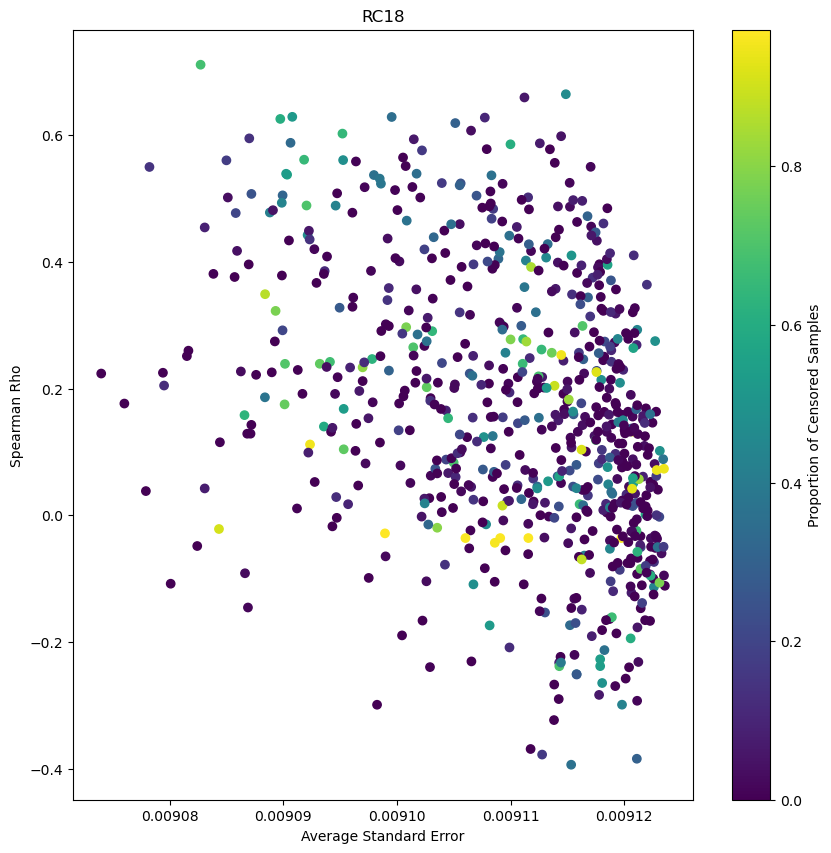

Spearman rho vs average standard error/deviation:, spearman's rho = -0.3973383508404852, pval = 3.124770177480534e-28


In [10]:
data = median_rho_feature
x, y, mode = 'ave_ave_se', 'median_rho', 'se'
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(x=data[x], y=data[y], c=data['censor_prop'])
# plt.xlim(left=1)
if mode == 'std':
    plt.xlabel('Average Standard Deviation')
elif mode == 'se':
    plt.xlabel('Average Standard Error')
# plt.axline((0, 1), slope=-1)
plt.ylabel('Spearman Rho')
plt.colorbar(label='Proportion of Censored Samples')
plt.title(f'{sub_dir[target - 1]}')
plt.show()
rho, pval = spearmanr(data[x], data[y])
print(f"Spearman rho vs average standard error/deviation:, spearman's rho = {rho}, pval = {pval}")

# Box plot for median rho by iteration

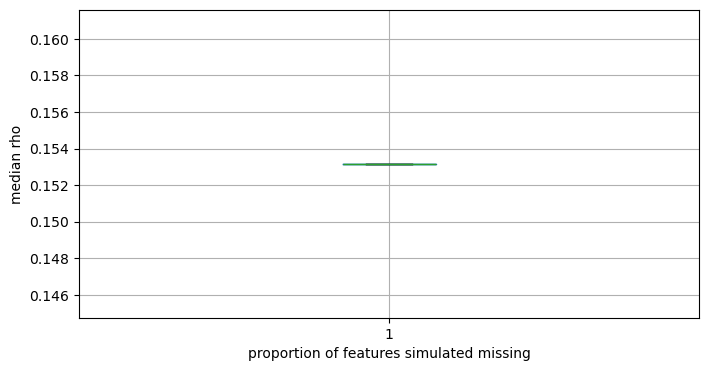

In [11]:
data = median_rho_iter
plt.rcParams['figure.figsize'] = [8, 4]
boxplot = (data
           .reset_index()
           .pivot(columns="f_test_prop", values="median_rho")
           .boxplot())
# plt.ylim([-1,1])
plt.ylabel('median rho')
plt.xlabel('proportion of features simulated missing')
plt.show()

# Bar plot for median rho by metabolite

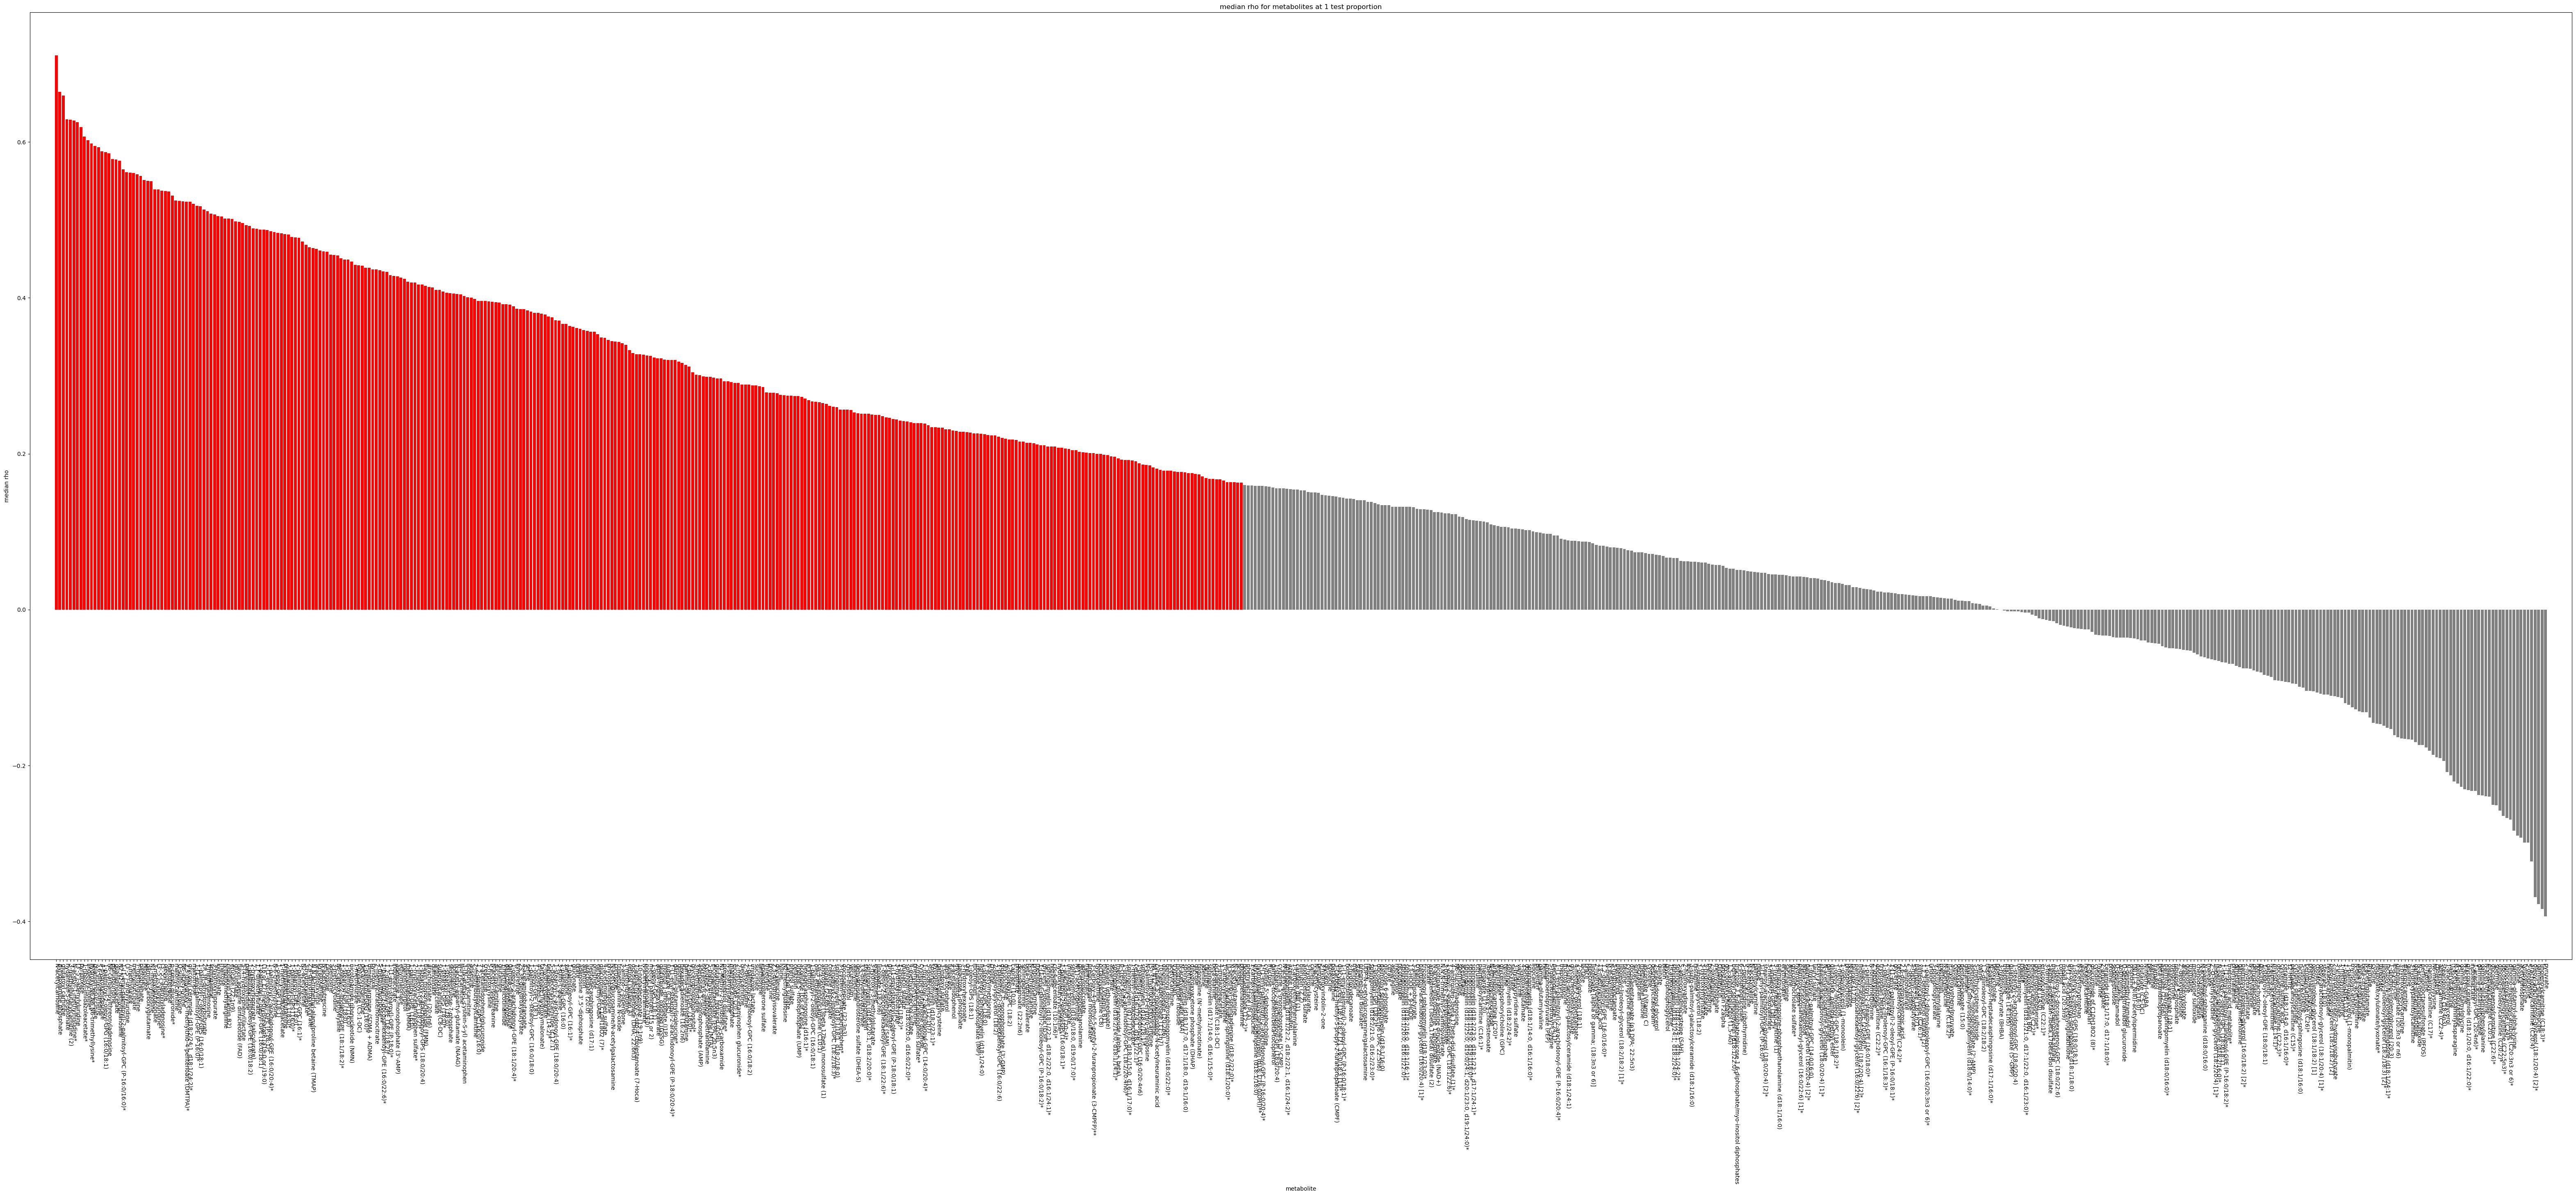

In [12]:
data = median_rho_feature
bar_df = (data.sort_values(by=["median_rho"], ascending=False)
          .assign(
    color=lambda df: df.apply(lambda row: 'red' if row['sig_in_most'] and row['median_rho'] > 0 else 'grey',
                              axis=1)))

plt.rcParams['figure.figsize'] = [80, 30]
plt.bar(bar_df["feature"], bar_df["median_rho"], color=bar_df["color"])
plt.xlabel("metabolite")
plt.ylabel("median rho")
plt.title(f'median rho for metabolites at {f_test_prop} test proportion')
plt.xticks(rotation=-90)
plt.margins(x=0.01)
plt.show()

# Plot the scatterplot of actual vs predicted ranks for specific metabolites

/tmp/ipykernel_2501066/2153291661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['size'] = [10 * count[(xx, yy)] for xx, yy in zip(test['actual_rank'], test['predicted_rerank'])]


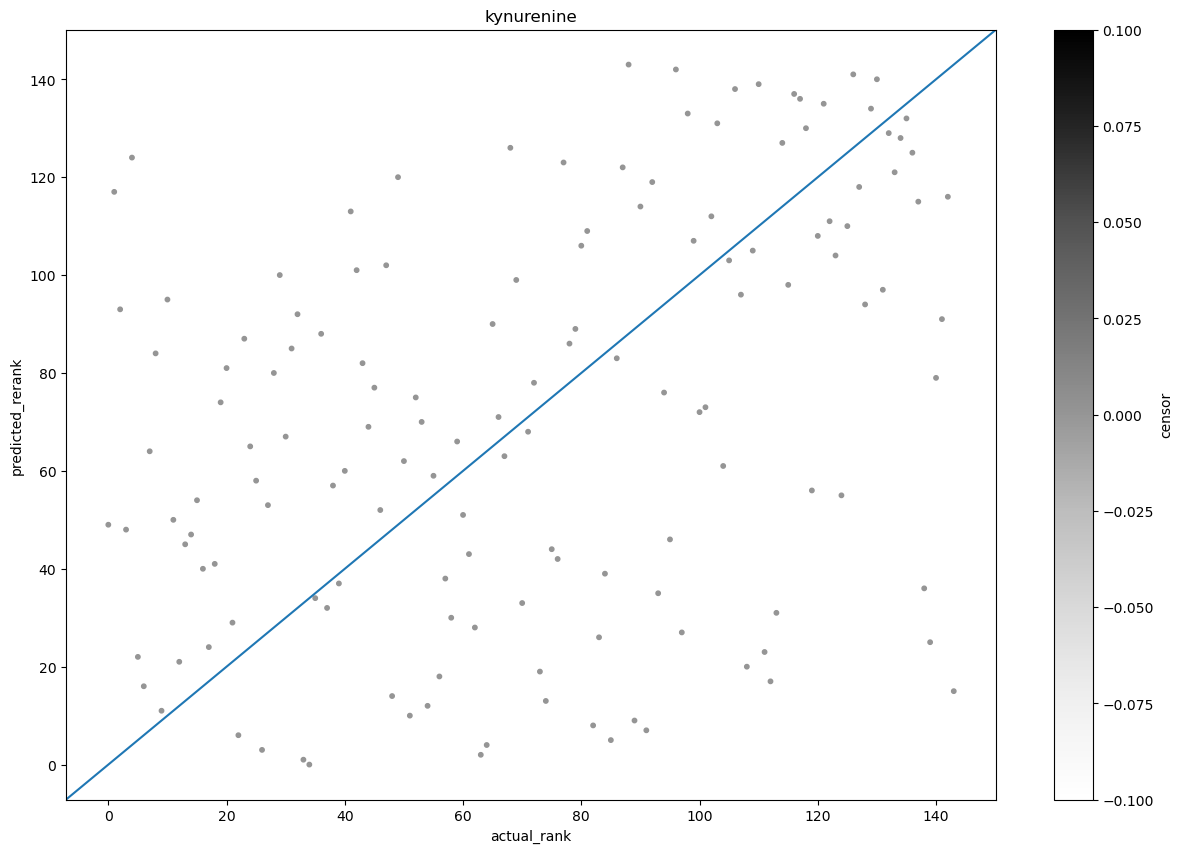

Actual vs predicted ranks for kynurenine: spearman's rho = 0.38624708624708626, pval = 1.7402739903198443e-06


In [15]:
data, met, mode = actual_pred_res_df, 'kynurenine', 'censor'
test = data.loc[data['feature'] == met]
count = Counter(zip(test['actual_rank'], test['predicted_rerank']))
test['size'] = [10 * count[(xx, yy)] for xx, yy in zip(test['actual_rank'], test['predicted_rerank'])]
plt.rcParams['figure.figsize'] = [15, 10]
if mode == 'iteration':
    test.plot.scatter(x='actual_rank', y='predicted_rerank', c='iteration', s='size')
if mode == 'censor':
    test.plot.scatter(x='actual_rank', y='predicted_rerank', c='censor', s='size')
plt.axline((0, 0), slope=1)
plt.title(met)
plt.show()
rho, pval = spearmanr(test['actual_rank'], test['predicted_rerank'])
print(f"Actual vs predicted ranks for {met}: spearman's rho = {rho}, pval = {pval}")